In [ ]:
pip install transformers


In [2]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
plt.style.use('ggplot')
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

I used %0.3 of data because the colab didnt allow me to train my model accoring the limit time I have.

In [16]:
# Read in data
df = pd.read_csv('train.csv')
df = df.sample(frac=0.3, random_state=42)

In [17]:
df

,id,label,tweet
12227,12228,0,@user âmy mom says my smile is captivatingâ...
14709,14710,0,"in 3 days i will be meeting my sis-n-law, coun..."
19319,19320,0,hating the conservative homophobes using this ...
4308,4309,0,awee if this doesn't #scream #friday #acewe...
24055,24056,0,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...
...,...,...,...
20593,20594,0,#model i love u take with u all the time in ...
11682,11683,0,y is so afraid if they have done nothing wro...
10882,10883,0,4 weeks till i perform in a showcase at @user ...
6084,6085,0,"""real #republicans"" have a chance to ""take the..."


<Axes: title={'center': 'count of review by stars'}>

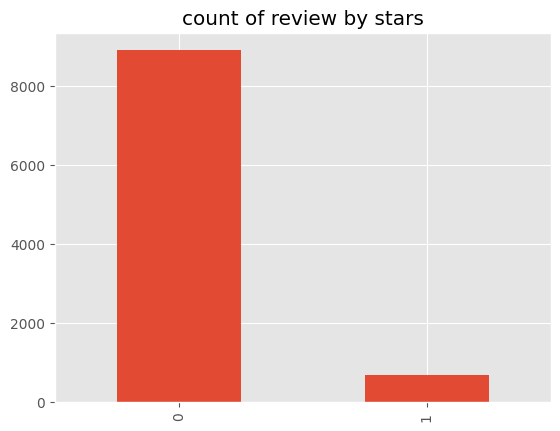

In [18]:
df.label.value_counts().sort_index().plot(kind='bar', title = 'count of review by stars')

# NLTK PreProcessing | Sentiment polarity


In [19]:
example = df['tweet'][250]
tokens = nltk.word_tokenize(example)[1:20]
sentiment = SentimentIntensityAnalyzer()
print(sentiment.polarity_scores('These Albanese gummi bears and rings and so on are very good and tasty and high quality'))
print(sentiment.polarity_scores('this is the worst thing i have ever'))

{'neg': 0.0, 'neu': 0.834, 'pos': 0.166, 'compound': 0.4927}
{'neg': 0.406, 'neu': 0.594, 'pos': 0.0, 'compound': -0.6249}


In [20]:
result = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  text = row['tweet']
  id = row ['id']
  result[id] = sentiment.polarity_scores(text)

  0%|          | 0/9589 [00:00<?, ?it/s]

In [21]:
vaders = pd.DataFrame(result).T
vaders = vaders.reset_index().rename(columns = {'index' : 'id'})
vaders = vaders.merge(df, how='right')
vaders

,id,neg,neu,pos,compound,label,tweet
0,12228,0.000,0.698,0.302,0.7574,0,@user âmy mom says my smile is captivatingâ...
1,14710,0.000,1.000,0.000,0.0000,0,"in 3 days i will be meeting my sis-n-law, coun..."
2,19320,0.436,0.564,0.000,-0.9341,0,hating the conservative homophobes using this ...
3,4309,0.000,1.000,0.000,0.0000,0,awee if this doesn't #scream #friday #acewe...
4,24056,0.000,1.000,0.000,0.0000,0,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...
...,...,...,...,...,...,...,...
9584,20594,0.000,0.663,0.337,0.7249,0,#model i love u take with u all the time in ...
9585,11683,0.000,0.869,0.131,0.3724,0,y is so afraid if they have done nothing wro...
9586,10883,0.000,0.769,0.231,0.4588,0,4 weeks till i perform in a showcase at @user ...
9587,6085,0.079,0.791,0.130,0.2244,0,"""real #republicans"" have a chance to ""take the..."


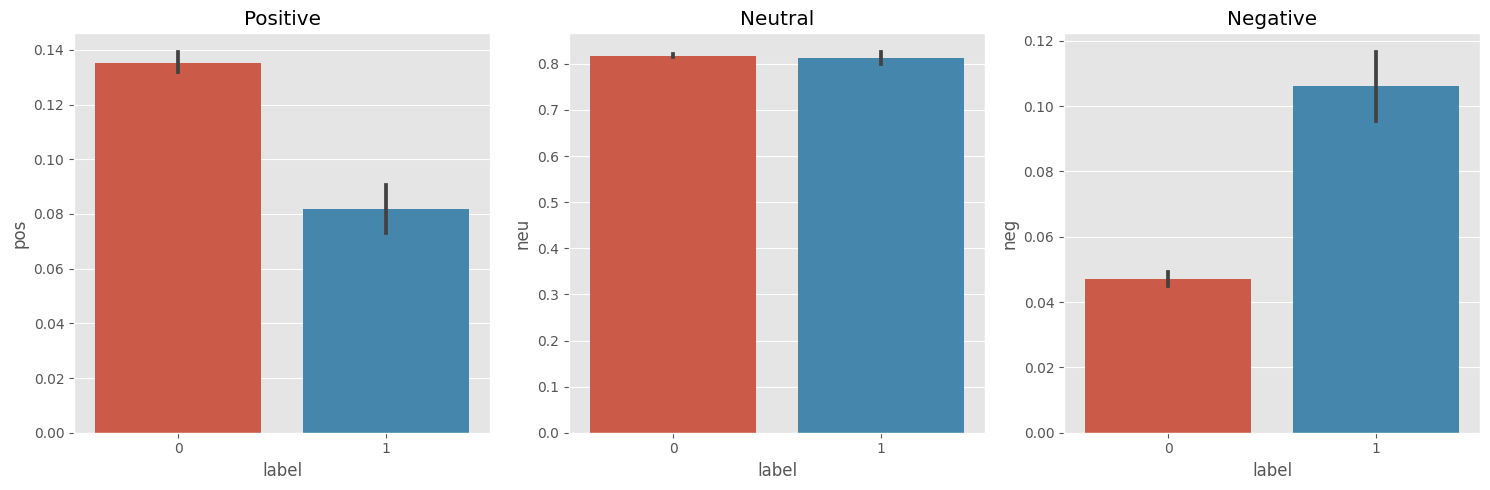

In [22]:
fiq, axs = plt.subplots(1, 3, figsize= (15, 5))
sns.barplot(data= vaders, x='label', y='pos', ax = axs[0])
sns.barplot(data= vaders, x='label', y='neu', ax = axs[1])
sns.barplot(data= vaders, x='label', y='neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Alberta Model

In [23]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [24]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [29]:
def Sentiment_analysis_roberta(example):
    encoded = tokenizer(example, return_tensors='pt')
    output = model(**encoded)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dec = {
        'scores_neg' : scores[0],
        'scores_neu' : scores[1],
        'scores_pos' : scores[2]
    }
    return scores_dec


Sentiment_analysis_roberta(df['tweet'][200])

{'scores_neg': 0.0043192096, 'scores_neu': 0.25549346, 'scores_pos': 0.7401873}

# Predict on entire Data

In [26]:
result = {}

for i, row in tqdm(df.iterrows(), total= len(df)):
  try:
    text = row['tweet']
    id = row['id']
    veder_result = sentiment.polarity_scores(text)

    vader_result_rename = {}
    for key, value in veder_result.items():
      vader_result_rename[f"vader_{key}"]  = value

    roberta_result = Sentiment_analysis_roberta(text)
    both_models = {**vader_result_rename, **roberta_result}
    result[id] = both_models
  except RuntimeError:
    print(f'Broke for id {id}')

  0%|          | 0/9589 [00:00<?, ?it/s]

In [34]:
vaders= pd.DataFrame(result).T
vaders= vaders.reset_index().rename(columns ={'index':'id'})
vaders= vaders.merge(df, how='right')
vaders

,id,vader_neg,vader_neu,vader_pos,vader_compound,scores_neg,scores_neu,scores_pos,label,tweet
0,12228,0.000,0.698,0.302,0.7574,0.001416,0.036537,0.962046,0,@user âmy mom says my smile is captivatingâ...
1,14710,0.000,1.000,0.000,0.0000,0.001626,0.283366,0.715008,0,"in 3 days i will be meeting my sis-n-law, coun..."
2,19320,0.436,0.564,0.000,-0.9341,0.971245,0.026284,0.002471,0,hating the conservative homophobes using this ...
3,4309,0.000,1.000,0.000,0.0000,0.336650,0.574591,0.088759,0,awee if this doesn't #scream #friday #acewe...
4,24056,0.000,1.000,0.000,0.0000,0.104248,0.631707,0.264045,0,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...
...,...,...,...,...,...,...,...,...,...,...
9584,20594,0.000,0.663,0.337,0.7249,0.002433,0.035329,0.962237,0,#model i love u take with u all the time in ...
9585,11683,0.000,0.869,0.131,0.3724,0.692532,0.288633,0.018836,0,y is so afraid if they have done nothing wro...
9586,10883,0.000,0.769,0.231,0.4588,0.000690,0.067898,0.931411,0,4 weeks till i perform in a showcase at @user ...
9587,6085,0.079,0.791,0.130,0.2244,0.339958,0.550488,0.109554,0,"""real #republicans"" have a chance to ""take the..."


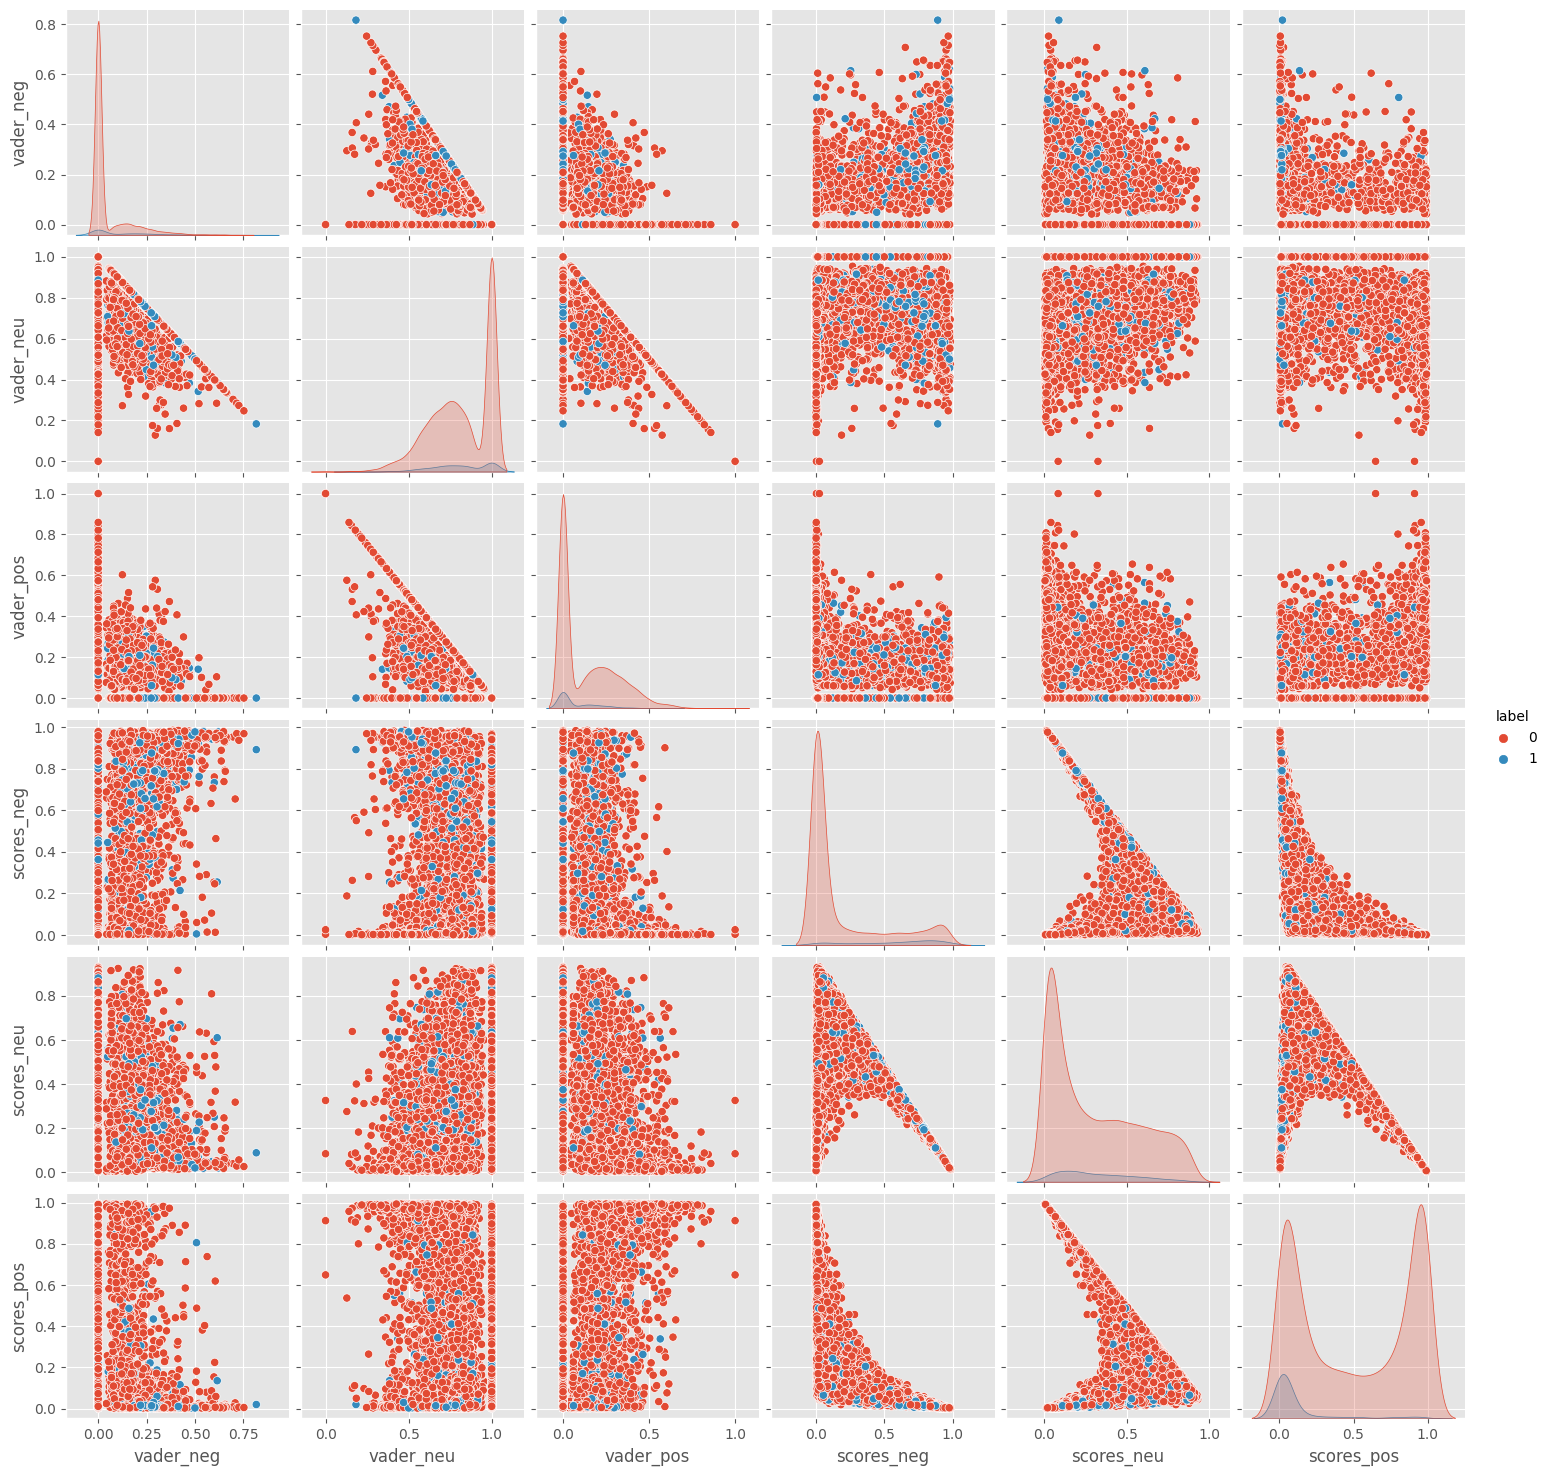

In [36]:
sns.pairplot(vaders,
             vars = ['vader_neg', 'vader_neu' ,'vader_pos','scores_neg', 'scores_neu', 'scores_pos'], hue= 'label')
plt.show()

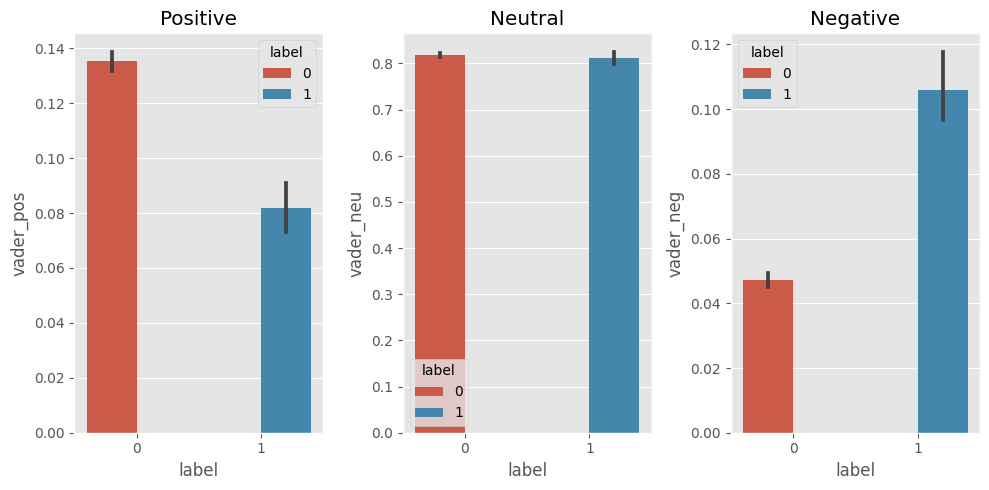

In [43]:
fiq, axs = plt.subplots(1, 3, figsize= (10, 5))
sns.barplot(data= vaders, x='label', y='vader_pos', ax = axs[0], hue='label')
sns.barplot(data= vaders, x='label', y='vader_neu', ax = axs[1], hue='label')
sns.barplot(data= vaders, x='label', y='vader_neg', ax = axs[2], hue='label')
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

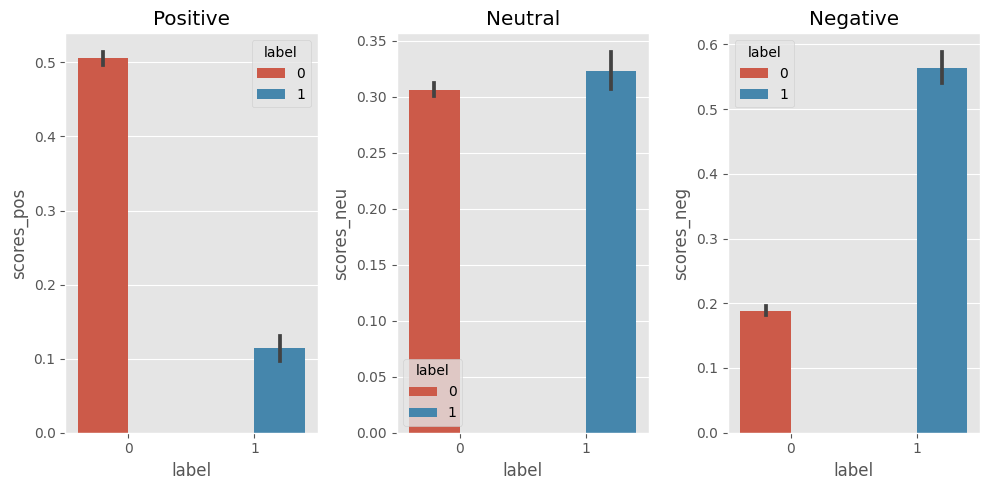

In [44]:
fiq, axs = plt.subplots(1, 3, figsize= (10, 5))
sns.barplot(data= vaders, x='label', y='scores_pos', ax = axs[0], hue='label')
sns.barplot(data= vaders, x='label', y='scores_neu', ax = axs[1], hue='label')
sns.barplot(data= vaders, x='label', y='scores_neg', ax = axs[2], hue='label')

axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()